In [3]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import ast
import json
import operator
from tabulate import tabulate

PREPROCESSED_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Geodo', 'Gmail', 'Htbot', 'Miuref', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Virut', 'Weibo', 'WorldOfWarcraft']
PAYLOAD_CLASSES = ['BitTorrent', 'Cridex', 'FTP', 'Gmail', 'Htbot', 'Neris', 'Nsis-ay', 'Outlook', 'SMB', 'Shifu', 'Virut', 'Weibo']

# Standard plots for one training task (model dataset combination)

In [3]:
csv_files = ["/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/payload/vgg-19/notop/scores1.csv"] #Insert files in this list (files need to be in order of training --> first hyperparameter opt.)

train_losses = []
val_losses = []
val_accuracies = []
val_f1 = []
val_kappa = []


for file in csv_files:
    if file.endswith(".csv"):
        df = pd.read_csv(file)
        # Training loss will be tracked during the whole training process
        train_losses += df["training-losses"].to_list()

        val_losses += df["loss"].to_list()
        val_accuracies += df["accuracy"].to_list()
        val_f1 += df["macro-f1"].to_list()
        val_kappa += df["kappa"].to_list()
        
n_val_epochs = len(val_losses)
val_epochs = range(1, n_val_epochs+1)
# since we save multiple train losses per epoch our csv contains list strings 
train_losses = [ast.literal_eval(t) for t in train_losses]
# we only want to print the train loss at the end of the epoch
train_losses = [sublist[-1] for sublist in train_losses]
n_train_epochs = len(train_losses)
train_epochs = range(1, n_train_epochs+1)
print(n_train_epochs)
print(n_val_epochs)
plt.figure(figsize=(n_train_epochs/4, 8))
plt.plot(train_epochs, train_losses, marker='x', label="Training Set")
plt.plot(val_epochs, val_losses, marker='x', label="Validation Set")
plt.xticks(val_epochs)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("val_train_loss.svg", format="svg")

plt.clf()

plt.figure(figsize=(n_val_epochs/4, 8))
plt.plot(val_epochs, val_accuracies, label = "accuracy", marker='x')
plt.plot(val_epochs, val_f1, label = "macro-f1", marker='*')
plt.plot(val_epochs, val_kappa, label = "kappa", marker="o")
plt.xlabel("epoch")
plt.xticks(val_epochs)
plt.ylabel("Scores from 0 to 1")
plt.legend()
plt.savefig("val_scores.svg", format="svg")

plt.clf()


20
20


<Figure size 500x800 with 0 Axes>

<Figure size 500x800 with 0 Axes>

# ROC Curve

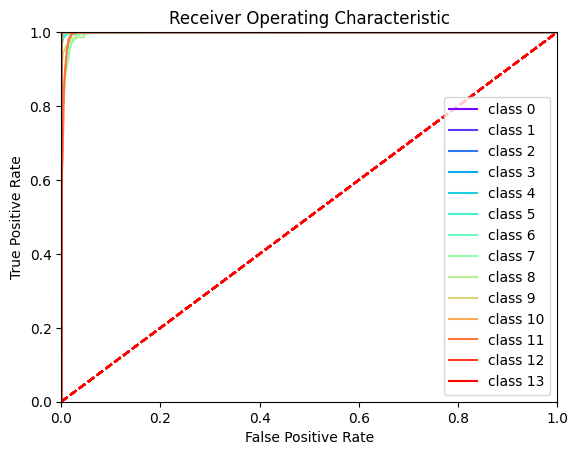

In [35]:
roc = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/roc.pt")
fpr = roc[0]
tpr = roc[1]
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(fpr))))
for label in range(len(fpr)):
    fpr_label = fpr[label].tolist()
    tpr_label = tpr[label].tolist()
    plt.plot(fpr_label, tpr_label, color = next(color), label = "class " + str(label))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg", format="svg")
plt.clf()

# Histogram of prediction distribution

In [34]:
distribution_json = '/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/bonus_scores.json'

with open(distribution_json, 'r') as f:
  distribution_dict = json.load(f)["Label_prediction_distribution"]
multiclass = True 


if multiclass:
    probability_true_label = []
    probability_other = []
    for label in distribution_dict.keys():
        predictions_label = distribution_dict[label]
        total_instances_label = len(predictions_label)
        for prediction in predictions_label:
            true_prediction = prediction[int(label)]
            probability_true_label.append(true_prediction)
            probability_other.append(1 - true_prediction)
        
        # calculate interquartile range for Freedman-Diaconis number of bins
        probability_true_label.sort()
        probability_other.sort()
        
        q3, q1 = np.percentile(probability_true_label, [75 ,25])
        iqr = q3 - q1
        bin_width = 2 * (q3 - q1) * np.cbrt(total_instances_label)
        n_bins = round((max(probability_true_label) - min(probability_true_label)) / bin_width)
        
        plt.hist(probability_true_label, bins=n_bins, label="true_class", log=True)
        #plt.hist(probability_other, bins=n_bins, label="other_classes", log=True)
        plt.ylabel('Frequency of prediction')
        plt.xlabel('Predicted Probability by Model')
        plt.legend()
        plt.savefig("histogram_class" + label + ".svg", format="svg")
        plt.clf()


<Figure size 640x480 with 0 Axes>

In [ ]:
# Barchart most frequently mistaken classes

In [7]:
mistakes_json = '/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/bonus_scores.json'

with open(mistakes_json, 'r') as f:
  mistakes = json.load(f)["Wrong_prediction_classes"]

count_per_combination = {}
for mistake in mistakes:
  mistake_sorted = list(mistake)
  mistake_sorted.sort()
  mistake_sorted = tuple(mistake_sorted)
  if mistake_sorted in count_per_combination.keys():
    count_per_combination[mistake_sorted] += 1
  else:
    count_per_combination[mistake_sorted] = 1

top5_keys = sorted(count_per_combination, key=count_per_combination.get, reverse=True)[:5]
top5_values = [count_per_combination[key] for key in top5_keys]
top5_keys = [str(key) for key in top5_keys]
plt.bar(top5_keys, top5_values, align='center', alpha=0.5)
plt.xlabel('mistaken classes')
plt.ylabel('occurance of mistake')
plt.savefig("frequent_mistakes.svg", format="svg")
plt.clf()




<Figure size 640x480 with 0 Axes>

# Confusion Matrix

In [6]:
cf_matrix = torch.load("/home/manuel/Bachelorarbeit/results/saved_models-new/multiclass/preprocessed/vgg-19/notop/confusion_matrix.pt")
print(list(zip([i for i in range(cf_matrix.shape[0])], PREPROCESSED_CLASSES)))
df_cm = pd.DataFrame(cf_matrix,
                    columns = [i for i in range(cf_matrix.shape[0])])
print(tabulate(df_cm, headers = 'keys', tablefmt = 'psql'))

[(0, 'BitTorrent'), (1, 'Cridex'), (2, 'FTP'), (3, 'Geodo'), (4, 'Gmail'), (5, 'Htbot'), (6, 'Miuref'), (7, 'Neris'), (8, 'Nsis-ay'), (9, 'Outlook'), (10, 'SMB'), (11, 'Virut'), (12, 'Weibo'), (13, 'WorldOfWarcraft')]
+----+-----+------+------+------+-----+-----+-----+-----+-----+------+------+------+------+------+
|    |   0 |    1 |    2 |    3 |   4 |   5 |   6 |   7 |   8 |    9 |   10 |   11 |   12 |   13 |
|----+-----+------+------+------+-----+-----+-----+-----+-----+------+------+------+------+------|
|  0 | 599 |    0 |    0 |    0 |   1 |   0 |   0 |   0 |   0 |    0 |    0 |    0 |    0 |    0 |
|  1 |   0 | 2457 |    0 |    0 |   0 |   0 |   0 |   0 |   0 |    0 |    0 |    0 |    0 |    0 |
|  2 |   0 |    0 | 1488 |    0 |   1 |   0 |   0 |   0 |   0 |    0 |    0 |    0 |    0 |    0 |
|  3 |   0 |    0 |    0 | 1070 |   0 |   3 |   1 |   1 |   0 |    0 |    0 |    0 |    0 |    0 |
|  4 |   0 |    0 |    0 |    0 | 609 |   0 |   0 |   0 |   0 |    8 |    0 |    0 |    0